Notebook for comparing the outputted beta values under different MVN samplers

In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
OUTPUTS_DIR = 'output/aug3benchmarking/'

In [3]:
def process_filename(filename):
    """Quick function to process a filename; coded up specific to the experiment run on Aug 3"""
    sampler_type = filename.split('_')[1]
    n_max_iterations = None
    if 'maxCGMiters' in filename:
        n_max_iterations = filename.split('maxCGMiters=')[1].split('_')[0] # extremely hacky but it works
    return sampler_type, n_max_iterations

In [4]:
sampler_to_effect_vector = {}

for filename in os.listdir(OUTPUTS_DIR):
    sampler_type, n_max_iterations = process_filename(filename)

    sampler_name = sampler_type
    if 'cgm' in sampler_type:
        sampler_name += '_maxCGMiters=' + n_max_iterations

    with open(os.path.join(OUTPUTS_DIR, filename)) as f:
        reader = csv.reader(f, delimiter='\t')

        effect_vector = []
        for line in reader:
            # TODO I believe the SNPs are always outputted in the same order, but as a sanity check we should probably do something with the IDs
            effect_size = line[-1]
            effect_size = float(effect_size)
            effect_vector.append(effect_size)
        effect_vector = np.array(effect_vector)
        sampler_to_effect_vector[sampler_name] = effect_vector

In [5]:
sampler_to_effect_vector.keys()

dict_keys(['precondcgm_maxCGMiters=25', 'precondcgm_maxCGMiters=10', 'vanilla', 'precondcgm_maxCGMiters=5', 'precondcgm_maxCGMiters=20', 'precondcgm_maxCGMiters=30', 'precondcgm_maxCGMiters=35', 'precondcgm_maxCGMiters=15'])

In [6]:
baseline_vector = sampler_to_effect_vector['vanilla']

sampler_to_correlation = {}

for sampler in sampler_to_effect_vector.keys():
    if sampler == 'vanilla':
        continue
    else:
        # must be precond by structure of Aug 3 experiment
        n_max_iters = int(sampler.split('_maxCGMiters=')[1])

        experimental_vector = sampler_to_effect_vector[sampler]

        correlation = np.corrcoef(baseline_vector, experimental_vector)[0,1] # the off-diagonal value
        sampler_to_correlation[sampler] = correlation

In [7]:
OTHER_BASELINE_RUN = 'output/aug3benchmarking1/2023-08-03T19:15:55Z_vanilla_exact_pst_eff_a1_b0.5_phi1e-02_chr22.txt'
with open(OTHER_BASELINE_RUN) as f:
    reader = csv.reader(f, delimiter='\t')

    baseline2_effect_vector = []
    for line in reader:
        # TODO I believe the SNPs are always outputted in the same order, but as a sanity check we should probably do something with the IDs
        effect_size = line[-1]
        effect_size = float(effect_size)
        baseline2_effect_vector.append(effect_size)
    baseline2_effect_vector = np.array(baseline2_effect_vector)

In [8]:
def plot_diagonal_vectors(v1, v2, v1_name, v2_name, title=None):
    """Generates a diagonal plot comparing two effect vectors `v1, v2`"""

    fig, ax = plt.subplots()
    plt.suptitle(title, fontsize=12, y=1)
    plt.title(f"Pearson correlation coefficient = {np.corrcoef(v1, v2)[0,1]:.3f}", fontsize=12)
    plt.xlabel(v1_name)
    plt.ylabel(v2_name)
    lims = [
        np.min([v1.min(), v2.min()]),
        np.max([v1.max(), v2.max()])
    ]
    ax.plot(lims, lims, color="gray")
    ax.axline((0, 0), slope=1.0, color='k')
    ax.set_aspect('equal', adjustable='box') 
    plt.plot(v1, v2,'.', markersize=4)

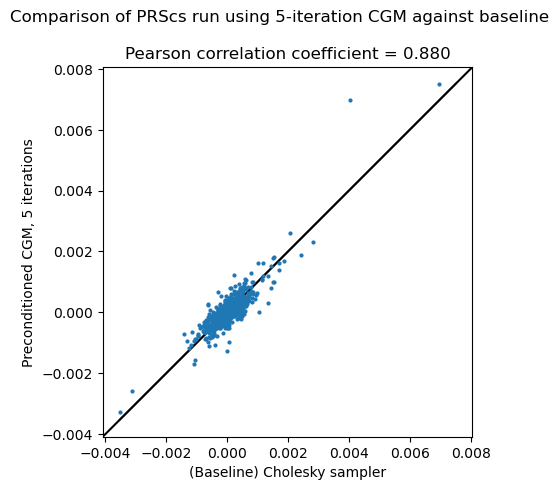

In [10]:
n_iters = 5
cgm_filename = f'precondcgm_maxCGMiters={n_iters}'
plot_diagonal_vectors(baseline_vector, sampler_to_effect_vector[cgm_filename], '(Baseline) Cholesky sampler', f'Preconditioned CGM, {n_iters} iterations', f'Comparison of PRScs run using {n_iters}-iteration CGM against baseline')

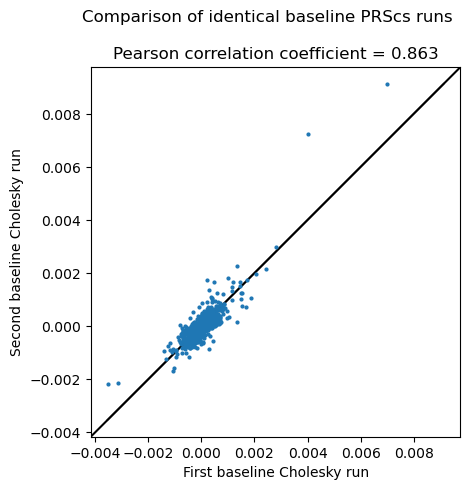

In [17]:
plot_diagonal_vectors(baseline_vector, baseline2_effect_vector, 'First baseline Cholesky run', 'Second baseline Cholesky run', 'Comparison of identical baseline PRScs runs')